In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 

In [2]:
data = pd.read_csv('./datasets/regression/housing.csv')

print(data.head(10))

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                 NaN        880.0           129.0   
1    -122.22     37.86                 NaN       7099.0          1106.0   
2    -122.24     37.85                 NaN       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0   

In [3]:
print(data.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20637.000000  20640.000000   
mean    -119.569704     35.631861           28.638126   2635.763081   
std        2.003532      2.135952           12.585015   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

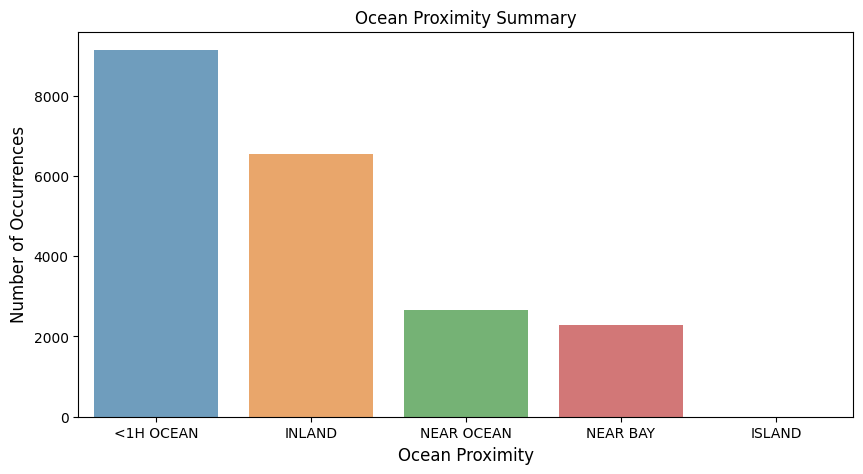

In [4]:
op_count = data['ocean_proximity'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=op_count.index, y=op_count.values, alpha=0.7)
plt.title('Ocean Proximity Summary')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ocean Proximity', fontsize=12)
plt.show()

In [9]:
# target dataframe: housing
target = "median_house_value"
features = list(data.columns.drop("median_house_value"))
feature_df = data[features]

prediction_df = data

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
data[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()


sample_size = np.min([10000, data.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if data[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if data[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", MinMaxScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)


['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']
[]


In [10]:
# Train and Test split
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison_list = []

##### End of Data Processing Pipeline #####

In [12]:
random_forest_regression_param_grid = {
"random_forest_regression__n_estimators": np.arange(1, 15, 20),
"random_forest_regression__max_depth": np.arange(5, 50, 10),
"random_forest_regression__min_samples_leaf": np.arange(1, 50, 20),
}


# Create the pipeline
random_forest_regression_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest_regression', RandomForestRegressor())
])

# Create the grid search
random_forest_regression_grid_search = GridSearchCV(estimator=random_forest_regression_pipe, param_grid=random_forest_regression_param_grid, cv=5, scoring=make_scorer(mean_squared_error), verbose=3)
random_forest_regression_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END random_forest_regression__max_depth=5, random_forest_regression__min_samples_leaf=1, random_forest_regression__n_estimators=1;, score=4939315257.912 total time=   0.0s
[CV 2/5] END random_forest_regression__max_depth=5, random_forest_regression__min_samples_leaf=1, random_forest_regression__n_estimators=1;, score=4893586934.050 total time=   0.0s
[CV 3/5] END random_forest_regression__max_depth=5, random_forest_regression__min_samples_leaf=1, random_forest_regression__n_estimators=1;, score=5248617286.218 total time=   0.0s
[CV 4/5] END random_forest_regression__max_depth=5, random_forest_regression__min_samples_leaf=1, random_forest_regression__n_estimators=1;, score=4869896405.261 total time=   0.0s
[CV 5/5] END random_forest_regression__max_depth=5, random_forest_regression__min_samples_leaf=1, random_forest_regression__n_estimators=1;, score=5110307172.976 total time=   0.0s
[CV 1/5] END random_forest_regress

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleIm...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity'])])),
                                       ('random_forest_regression',
                                        RandomForestRegressor())]),
             param_grid={'random_forest_regression__max_depth': array([ 5, 15, 25, 35, 45]),
                         'random_forest_regression__min_samples_leaf': array([ 1, 21, 41]),
                         'random_forest_regression__n_estimators': array([1])},
             scoring=make_scorer(mean_squared_error), verbose=3)

In [13]:
# Get the best hyperparameters
random_forest_regression_best_estimator = random_forest_regression_grid_search.best_estimator_

# Store results as a dataframe  
random_forest_regression_search_results = pd.DataFrame(random_forest_regression_grid_search.cv_results_)

print(random_forest_regression_search_results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.078174      0.004724         0.009264        0.001332   
1        0.081659      0.011655         0.009006        0.001630   
2        0.072725      0.004279         0.008605        0.000836   
3        0.163280      0.009415         0.009631        0.002110   
4        0.109236      0.002586         0.009234        0.000986   
5        0.116165      0.035922         0.008356        0.001470   
6        0.186465      0.011810         0.008112        0.000381   
7        0.107788      0.002221         0.009108        0.001012   
8        0.102954      0.009784         0.009736        0.001516   
9        0.223820      0.036541         0.011728        0.001731   
10       0.120417      0.024337         0.008938        0.001087   
11       0.094469      0.004059         0.008335        0.001475   
12       0.190644      0.026291         0.008430        0.001633   
13       0.103740      0.002489         0.010046

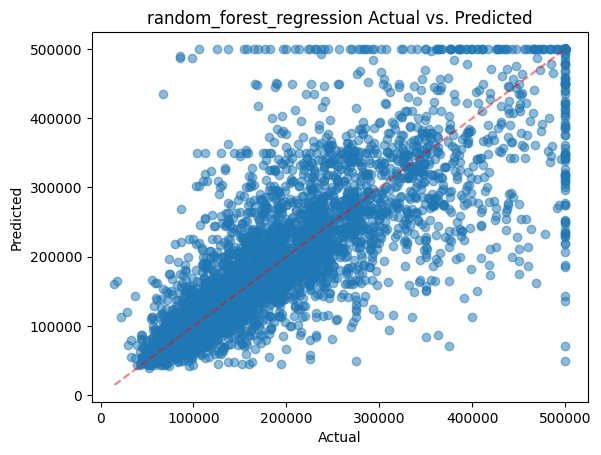

In [15]:
# Model metrics

# Generate Predictions
random_forest_regression_predictions = random_forest_regression_best_estimator.predict(X_test)
random_forest_regression_predictions_df = pd.DataFrame(random_forest_regression_best_estimator.predict(X_test))

# Generate Model Metrics
random_forest_regression_r2_score = r2_score(y_test, random_forest_regression_predictions_df.iloc[:,0])
random_forest_regression_mean_squared_error = mean_squared_error(y_test, random_forest_regression_predictions_df.iloc[:,0])
random_forest_regression_explained_variance_score = explained_variance_score(y_test, random_forest_regression_predictions_df.iloc[:,0])
random_forest_regression_performance_metrics = [['random_forest_regression','r2_score', random_forest_regression_r2_score], 
                                  ['random_forest_regression','mean_squared_error',random_forest_regression_mean_squared_error],
                                  ['random_forest_regression','explained_variance_score', random_forest_regression_explained_variance_score]]
random_forest_regression_performance_metrics = pd.DataFrame(random_forest_regression_performance_metrics, columns=['model','metric', 'value'])

# Generate Actual vs Predicted Plot
random_forest_regression_actual_predicted_plot, random_forest_regression_actual_predicted_plot_ax = plt.subplots()
random_forest_regression_actual_predicted_plot = random_forest_regression_actual_predicted_plot_ax.scatter(x=y_test, y=random_forest_regression_predictions_df.iloc[:,0], alpha=0.5)
# Add diagonal line
random_forest_regression_actual_predicted_plot_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.5)
# Set axis labels and title
random_forest_regression_actual_predicted_plot_ax.set_xlabel('Actual')
random_forest_regression_actual_predicted_plot_ax.set_ylabel('Predicted')
random_forest_regression_actual_predicted_plot_ax.set_title(f'random_forest_regression Actual vs. Predicted')
plt.show(block=False)

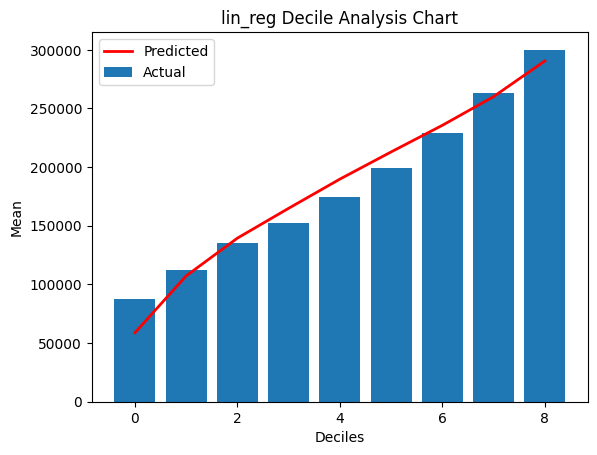

In [16]:
# Generate Decile Lift Chart
# Calculate the deciles based on the residuals
random_forest_regression_deciles = np.percentile(random_forest_regression_predictions, np.arange(0, 100, 10))
# Calculate the mean actual and predicted values for each decile
random_forest_regression_mean_actual = []
random_forest_regression_mean_predicted = []
for i in range(len(random_forest_regression_deciles) - 1):
    mask = (random_forest_regression_predictions >= random_forest_regression_deciles[i]) & (random_forest_regression_predictions < random_forest_regression_deciles[i + 1])
    random_forest_regression_mean_actual.append(np.mean(y_test[mask]))
    random_forest_regression_mean_predicted.append(np.mean(random_forest_regression_predictions[mask]))

# Create a bar chart of the mean actual and predicted values for each decile
random_forest_regression_lift_plot, random_forest_regression_lift_plot_ax = plt.subplots()
random_forest_regression_lift_plot_ax.bar(np.arange(len(random_forest_regression_mean_actual)), random_forest_regression_mean_actual, label='Actual')
random_forest_regression_lift_plot_ax.plot(np.arange(len(random_forest_regression_mean_predicted)), random_forest_regression_mean_predicted, color='red', linewidth=2, label='Predicted')
random_forest_regression_lift_plot_ax.set_xlabel('Deciles')
random_forest_regression_lift_plot_ax.set_ylabel('Mean')
random_forest_regression_lift_plot_ax.set_title(f'random_forest_regression Decile Analysis Chart')
random_forest_regression_lift_plot_ax.legend()
plt.show(block=False)

In [16]:
model_comparison_list.append(random_forest_regression_performance_metrics)##### End of Model Pipeline for Random Forest Regression #####
##### Model Comparison #####

table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'r2_score']
print(table)
print(f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}")


# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(prediction_df)
print('Predictions from best model are stored in test_predictions')

                      model    metric     value
0  random_forest_regression  r2_score  0.605728
The best model is random_forest_regression with 0.6057282966129015 as r2_score
Predictions from best model are stored in test_predictions
